In [6]:
import jax
import jax.numpy as jnp
from flows.glow import GLOW

import matplotlib.pyplot as plt

from functools import partial
from train import sample
from data import postprocess

    train_ds: Training dataset iterator (e.g. tensorflow dataset)
    val_ds: Validation dataset (optional)
    num_samples: Number of samples to generate at each epoch
    image_size: Input image size
    num_channels: Number of channels in input images
    num_bits: Number of bits for discretization
    init_lr: Initial learning rate (Adam)
    num_epochs: Numer of training epochs
    num_sample_epochs: Visualize sample at this interval
    num_warmup_epochs: Linear warmup of the learning rate to init_lr
    num_save_epochs: save mode at this interval
    steps_per_epochs: Number of steps per epochs
    K: Number of flow iterations in the GLOW model
    L: number of scales in the GLOW model
    nn_width: Layer width in the Affine Coupling Layer
    sampling_temperature: Smoothing temperature for sampling from the 
        Gaussian priors (1 = no effect)
    learn_top_prior: Whether to learn the prior for highest latent variable zL.
        Otherwise, assumes standard unit Gaussian prior
    key: Random seed

In [114]:
config_dict = {
        'image_path': "../../datasets/celeba/img_align_celeba",
        'train_split': 0.6,
        'image_size': 64,
        'num_channels': 3,
        'num_bits': 5,
        'batch_size': 10,
        'K': 1,
        'L': 1,
        'nn_width': 10, 
        'learn_top_prior': True,
        'sampling_temperature': 0.7,
        'init_lr': 1e-3,
        'num_epochs': 13,
        'num_warmup_epochs': 1,
        'num_sample_epochs': 0.2, # Fractional epochs for sampling because one epoch is quite long 
        'num_save_epochs': 5,
        'identity_init': False,
    }

output_hw = config_dict["image_size"] // 2 ** config_dict["L"]
output_c = config_dict["num_channels"] * 4**config_dict["L"] // 2**(config_dict["L"] - 1)
config_dict["sampling_shape"] = (output_hw, output_hw, output_c)

random_key = jax.random.PRNGKey(0)

In [116]:
model = GLOW(K=config_dict['K'],
             L=config_dict['L'], 
             nn_width=config_dict['nn_width'], 
             learn_top_prior=config_dict['learn_top_prior'],
             identity_init=config_dict['identity_init'])


shape = (config_dict['batch_size'],config_dict['image_size'],config_dict['image_size'],config_dict['num_channels'])

In [117]:
params = model.init(random_key, jax.random.normal(random_key,shape))

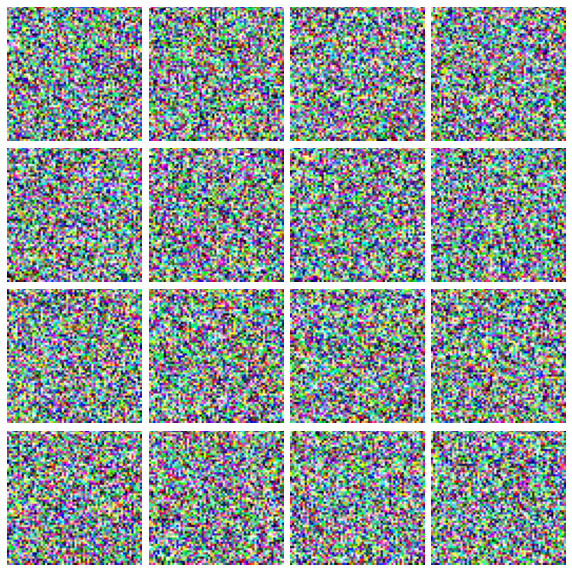

In [79]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(3), sampling_temperature=0.5,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]));

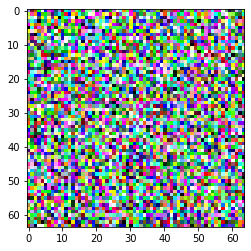

In [118]:
sampling_shape = (1,) + config_dict["sampling_shape"]
zL = jax.random.normal(random_key, sampling_shape)
zL = jax.ops.index_update(zL, jax.ops.index[:,:,:,2:], 0.)

x,*_ = model.apply(params,zL,sampling_temperature=0.5,reverse=True)
x = postprocess(x,num_bits=config_dict["num_bits"])

fig, ax = plt.subplots()
ax.imshow(x.squeeze())

In [52]:
import jax
import flax
import jax.numpy as jnp
import flax.linen as nn

# from einops import rearrange, reduce, repeat

import numpy as np

from flows.utils import ConvZeros
from flows.reshaping import squeeze, unsqueeze, Split
from flows.bijections import ActNorm, InvertibleConv1x1, AffineCoupling

class FlowStep(nn.Module):
    nn_width: int = 512
    key: jax.random.PRNGKey = jax.random.PRNGKey(0)

    identity_init: bool = True
        
    @nn.compact
    def __call__(self, x, logdet=0, reverse=False):
        out_dims = x.shape[-1]
        if not reverse:
            x, logdet = ActNorm()(x, logdet=logdet, reverse=False)           
            x, logdet = InvertibleConv1x1(out_dims, self.key)(x, logdet=logdet, reverse=False)
            x, logdet = AffineCoupling(out_dims, self.nn_width, identity_init=self.identity_init)(x, logdet=logdet, reverse=False)
        else:
            x, logdet = AffineCoupling(out_dims, self.nn_width, identity_init=self.identity_init)(x, logdet=logdet, reverse=True)
            x, logdet = InvertibleConv1x1(out_dims, self.key)(x, logdet=logdet, reverse=True)
            
            print(x)
            x, logdet = ActNorm()(x, logdet=logdet, reverse=True)
            
            print(x)
        return x, logdet



class GLOW2(nn.Module):
    K: int = 32                                       # Number of flow steps
    L: int = 3                                        # Number of scales
    nn_width: int = 512                               # NN width in Affine Coupling Layer
    learn_top_prior: bool = False                     # If true, learn prior N(mu, sigma) for zL
    key: jax.random.PRNGKey = jax.random.PRNGKey(0)
        
    identity_init: bool = True
        
    def flows(self, x, logdet=0, reverse=False, name=""):
        """K subsequent flows. Called at each scale."""
        for k in range(self.K):
            it = k + 1 if not reverse else self.K - k
            x, logdet = FlowStep(self.nn_width, self.key, identity_init=self.identity_init, name=f"{name}/step_{it}")(
                x, logdet=logdet, reverse=reverse)
            break
        return x, logdet
        
    
    @nn.compact
    def __call__(self, x, reverse=False, z=None, eps=None, sampling_temperature=1.0):
        """Args:
            * x: Input to the model
            * reverse: Whether to apply the model or its inverse
            * z (reverse = True): If given, use these as intermediate latents (deterministic)
            * eps (reverse = True, z!=None): If given, use these as Gaussian samples which are later 
                rescaled by the mean and variance of the appropriate prior.
            * sampling_temperature (reverse = True, z!=None): Sampling temperature
        """
        
        ## Inputs
        # Forward pass: Save priors for computing loss
        # Optionally save zs (only used for sanity check of reversibility)
        priors = []
        if not reverse:
            del z, eps, sampling_temperature
            z = []
        # In reverse mode, either use the given latent z (deterministic)
        # or sample them. For the first one, uses the top prior.
        # The intermediate latents are sampled in the `Split(reverse=True)` calls
        else:
            if z is not None:
                assert len(z) == self.L
            else:
                x *= sampling_temperature
                if self.learn_top_prior:
                    # Assumes input x is a sample from N(0, 1)
                    # Note: the inputs to learn the top prior is zeros (unconditioned)
                    # or some conditioning e.g. class information.
                    # If not learnable, the model just uses the input x directly
                    # see https://github.com/openai/glow/blob/master/model.py#L109
                    prior = ConvZeros(x.shape[-1] * 2, name="prior_top")(jnp.zeros(x.shape))
                    mu, logsigma = jnp.split(prior, 2, axis=-1)
                    x = x * jnp.exp(logsigma) + mu
                    
                
        ## Multi-scale model
        logdet = 0
        for l in range(self.L):
            # Forward
            if not reverse:
                x = squeeze(x)
                x, logdet = self.flows(x, logdet=logdet,
                                       reverse=False,
                                       name=f"flow_scale_{l + 1}/")
                if l < self.L - 1:
                    zl, x, prior = Split(
                        key=self.key, name=f"flow_scale_{l + 1}/")(x, reverse=False)
                else:
                    zl, prior = x, None
                    if self.learn_top_prior:
                        prior = ConvZeros(zl.shape[-1] * 2, name="prior_top")(jnp.zeros(zl.shape))
                z.append(zl)
                priors.append(prior)
                    
            # Reverse
            else:
                if l > 0:
                    x = Split(key=self.key, name=f"flow_scale_{self.L - l}/")(
                        x, reverse=True, 
                        z=z[-l - 1] if z is not None else None,
                        eps=eps[-l - 1] if eps is not None else None,
                        temperature=sampling_temperature)
                    
                x, logdet = self.flows(x, logdet=logdet, reverse=True,
                                       name=f"flow_scale_{self.L - l}/")
                
                x = unsqueeze(x)
                
        ## Return
        return x, z, logdet, priors

In [53]:
model = GLOW2(K=config_dict['K'],
             L=config_dict['L'], 
             nn_width=config_dict['nn_width'], 
             learn_top_prior=config_dict['learn_top_prior'],
             identity_init=config_dict['identity_init'])



In [54]:
zL = jax.random.normal(random_key, sampling_shape)
# zL = jax.ops.index_update(zL, jax.ops.index[:,:,:,:], 0.)


x = model.apply(params,zL,reverse=True)


[[[[ 1.9478022   2.8174772   2.6302288  ...  0.25273636  1.7824022
     0.14121525]
   [ 0.2286982  -1.7948405   1.351499   ...  0.20772563 -0.46142536
    -1.6916953 ]
   [-0.3997381  -0.42699274 -0.10370799 ... -0.20964321 -1.706288
    -0.7612239 ]
   ...
   [ 2.0214097   0.398979    0.29839054 ... -3.0448968  -0.5620484
     0.38343298]
   [ 3.0528579  -0.85509014  0.74313915 ...  2.2771735  -1.0837528
     0.81166077]
   [ 0.19390598  0.98293287  1.321699   ... -1.4635646   0.8563916
    -0.01961347]]

  [[ 0.53491384 -0.49066785  0.0690042  ... -0.88608444  1.7949326
    -0.19327235]
   [-1.0417391   0.23128757  1.1770164  ... -1.4507899  -2.0080147
     0.2826144 ]
   [-0.6134566   0.8091141   1.140245   ...  2.8992772  -0.00904807
    -0.44523275]
   ...
   [-0.18430944  2.1188233   0.3764895  ...  1.0327146  -1.0983073
     0.40366992]
   [-0.2328333  -0.5810473  -0.4923142  ... -0.9150176   0.9946243
    -2.0492601 ]
   [-0.3200296   0.64701086  0.80589    ... -0.02000137  1.